### This is Case-3: we assume t_0plus, X_oe=X_eo=0 are known and derive Xi_tilde, X_ee and X_oo (o refers to EC here)

In [201]:
import numpy as np; import pandas as pd; 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib as mpl; 
from openpyxl import load_workbook
import sympy as sy; from sympy import symbols,diff,Matrix,Eq, solve
fs=11; 
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
import os

##### Load data from: Table S3 in Jung 2023 paper. 
Jung, T.; Wang, A. A.; Monroe, C. W. Overpotential from Cosolvent Imbalance in Battery Electrolytes: LiPF(6) in EMC:EC. ACS Omega 2023, 8 (23), 21133-21144. DOI: 10.1021/acsomega.3c02088.

In [202]:
# The data file are the same from 
BasicPath = os.path.expanduser("~/EnvPBGEM_ECDrag2/Double_SimSave/Double_Trans/Input/")
Target  = 'Plot_Para/' 
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)
Path_Fig_save = BasicPath + Target

Path_Data_pre = os.path.expanduser("~/EnvPBGEM_ECDrag2/Double_SimSave/Double_Trans/Input/")
Save_fig = True
Jung_2023_Data = pd.read_excel(Path_Data_pre+'Jung_2023_ACS_Omega_Table_S3.xlsx')
Jung_2023_Data.head()

,omega_o,omega_e,rho (g/cm3),y_o,y_e,c_o (M),c_e (M),c_T (M)
0,0.0,0.00000,1.0061,0.0,0.00000,0.0,0.00000,9.66428
1,0.0,0.01394,1.0177,0.0,0.00950,0.0,0.09339,9.82622
2,0.0,0.07384,1.0674,0.0,0.04926,0.0,0.51886,10.53370
3,0.0,0.13444,1.1176,0.0,0.08776,0.0,0.98911,11.27030
4,0.0,0.19654,1.1691,0.0,0.12555,0.0,1.51262,12.04810


In [203]:
# Rename and change unit to International System of Units
Jung_2023_Data["rho (kg/m3)"]   = Jung_2023_Data["rho (g/cm3)"] * 1000
Jung_2023_Data["c_EC (mol/m3)"] = Jung_2023_Data["c_o (M)"] * 1000
Jung_2023_Data["c_e (mol/m3)"]  = Jung_2023_Data["c_e (M)"] * 1000
Jung_2023_Data["c_T (mol/m3)"]  = Jung_2023_Data["c_T (M)"] * 1000
Jung_2023_Data.drop('c_o (M)', axis=1, inplace=True)
Jung_2023_Data.drop('c_e (M)', axis=1, inplace=True)
Jung_2023_Data.drop('c_T (M)', axis=1, inplace=True)
Jung_2023_Data.drop('rho (g/cm3)', axis=1, inplace=True)
Jung_2023_Data.rename(columns={'omega_o': 'omega_EC'}, inplace=True)
Jung_2023_Data.rename(columns={'y_o': 'y_EC'}, inplace=True)

In [204]:
Jung_2023_Data.head()

,omega_EC,omega_e,y_EC,y_e,rho (kg/m3),c_EC (mol/m3),c_e (mol/m3),c_T (mol/m3)
0,0.0,0.00000,0.0,0.00000,1006.1,0.0,0.00,9664.28
1,0.0,0.01394,0.0,0.00950,1017.7,0.0,93.39,9826.22
2,0.0,0.07384,0.0,0.04926,1067.4,0.0,518.86,10533.70
3,0.0,0.13444,0.0,0.08776,1117.6,0.0,989.11,11270.30
4,0.0,0.19654,0.0,0.12555,1169.1,0.0,1512.62,12048.10


In [205]:
c_EC_max = max(Jung_2023_Data["c_EC (mol/m3)"].tolist())
c_e_max = max(Jung_2023_Data["c_e (mol/m3)"].tolist())
print(f"The max c_EC during Experiment is {c_EC_max}")
print(f"The max c_e during Experiment is {c_e_max}")

The max c_EC during Experiment is 9747.79
The max c_e during Experiment is 2324.16


Fit results for rho is rho = 1006.1  + 0.02235185918895445 * c_EC + 0.10065156540490541 * c_e
RMSE=6.724186328439609, R2=0.9955257527340647


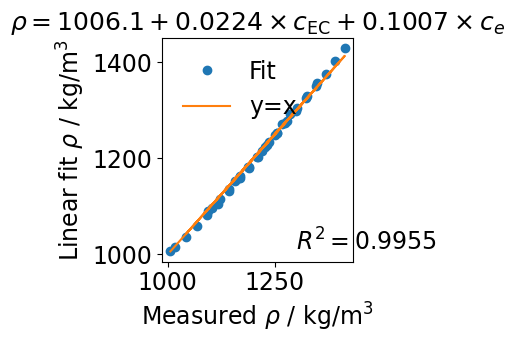

In [ ]:
# Fit density as a linear function of c_EC and c_e: rho = 1006.1  + rho_1 * c_EC + rho_2 * c_e
def Fit_rho(rho,c_EC,c_e):
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error, r2_score

    X = np.column_stack((c_EC, c_e))

    # Adjust rho by subtracting the constant 1006.1 from each value
    rho_0 = 1006.1
    adjusted_rho = [r - rho_0 for r in rho]

    # Create a linear regression model without fitting the intercept
    model = LinearRegression(fit_intercept=False)

    # Fit the model
    model.fit(X, adjusted_rho)

    # The coefficients rho_1 and rho_2
    rho_1, rho_2 = model.coef_

    # Predict adjusted rho values using the model and add back the constant
    rho_pred = model.predict(X) + 1006.1

    # Calculate RMSE and R^2
    rmse = np.sqrt(mean_squared_error(rho, rho_pred))
    r2 = r2_score(rho, rho_pred)
    # plot result:
    fig, ax = plt.subplots(figsize=(11/2.54,9.5/2.54), tight_layout='constrained')
    ax.plot(rho,rho_pred,"o",label="Fit")
    ax.plot(rho,rho,"-",label="y=x")
    ax.set_xlabel(r'Measured $\rho$ / $\mathrm{kg/m^3}$')
    ax.set_ylabel(r"Linear fit $\rho$ / $\mathrm{kg/m^3}$")
    equation = r'$\rho = 1006.1 + {:.4f} \times c_{{\text{{EC}}}} + {:.4f} \times c_e$'.format(rho_1, rho_2)
    ax.legend(loc='best',frameon=False) 
    x_pos = 0.70  # X position in normalized coordinates (e.g., 0.05 for 5% from the left)
    y_pos = 0.15  # Y position in normalized coordinates (e.g., 0.95 for 95% from the bottom, or near the top)
    #ax.text(x_pos, y_pos, f"R^2={r2:.4f}", fontsize=fs, transform=ax.transAxes, verticalalignment='top') 
    ax.text(x_pos, y_pos, r'$R^2 = {:.4f}$'.format(r2), fontsize=fs, transform=ax.transAxes, verticalalignment='top')
    ax.set_title(equation,fontsize=fs+1)
    if Save_fig:
        plt.savefig(Path_Fig_save + "/" +  f"Linear fit of rho.png", dpi=600)
        plt.savefig(Path_Fig_save + "/" +  f"Linear fit of rho.svg") 
    return rho_0,rho_1, rho_2, rho_pred, rmse, r2

rho  = Jung_2023_Data["rho (kg/m3)"].tolist() 
c_EC = Jung_2023_Data["c_EC (mol/m3)"].tolist()
c_e  = Jung_2023_Data["c_e (mol/m3)"].tolist()
rho_0, rho_1, rho_2, rho_pred, rmse, r2 = Fit_rho(rho,c_EC,c_e)
print(f"Fit results for rho is rho = {rho_0}  + {rho_1} * c_EC + {rho_2} * c_e")
print(f"RMSE={rmse}, R2={r2}")
# Get Fun_rho
def Fun_rho(c_e, c_EC):
    return rho_0  + rho_1 * c_EC + rho_2 * c_e

In [183]:
Case_No = 3

In [156]:
# define constant:   - This is from Taeho's measurement
V_bar_zero = 1.0347e-04 # m3/mol
V_bar_o= 6.5312e-05 # m3/mol
V_bar_e = 5.0943e-05 # m3/mol
m_bar_e  = 151.905*1e-3 #   kg/mol
# Xi_tilde = 3.2

In [157]:
# range: 0<y_o<0.75; 0.002<y_e<0.15
# actually during model, 0.2<y_o< 0.65

In [158]:
def LJP_1_Specie_y_np(y_e,T):   # ALL IN ISO Units, range limit: 0< y_e <= 0.15 
    # Eq. (13):
    R = 8.31446261815324
    F = 96485.3321
    aln = 1.491; a0 = 3.007; a1 = -8.168; a2 = 199.6
    delta_U = R*T/F*(
        aln * np.log(y_e) + a0 + a1*y_e  + a2 * y_e**2
    )
    return delta_U

def LJP_2_Species_y_np(y_e,y_EC):
    T = 298.15;
    # y0 = c0/cT;   y_e = ce/cT;
    # constant first
    R = 8.31446261815324; F = 96485.3321
    bln = 3.024; b0 = 8.233; b1 = -88.12; b2 = 477.9;
    p = 32.2;     q = -37.99;   r = -44.80
    # Eq. (14):
    delta_U_1to0 = R*T/F*(
        7.167 - 43.16*y_e**0.5 + 185.4*y_e - 402.4*y_e**1.5 
        + 236.9*y_e**2 + 253.7*y_e**2.5 - 408.1*y_e**3 
        + 2509*y_e**3.5 - 2886*y_e**4.5 + 1.174*np.log(y_e) 
    )
    # Eq. (18):
    delta_U_0to1 = R*T/F*(
        bln*np.log(y_e) + b0 + b1*y_e + b2*y_e**2
    )
    # Eq. (19):
    delta_U_ex = R*T/F*  y_EC  * (
        (1-y_EC-2*y_e) * (
        p + q*y_EC + r*(1-y_EC-2*y_e)
        )
    )
    # Eq. (17):
    delta_U = (
        ( 1 - y_EC/(1-2*y_e)  ) * delta_U_1to0 
        + y_EC/(1-2*y_e) * delta_U_0to1 
        + delta_U_ex
    )
    return delta_U # units: V


/tmp/ipykernel_6061/3269929872.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cop2 = mpl.cm.get_cmap("copper", len(Cases))


Text(0.5, 0, '$y_\\mathrm{e}$')

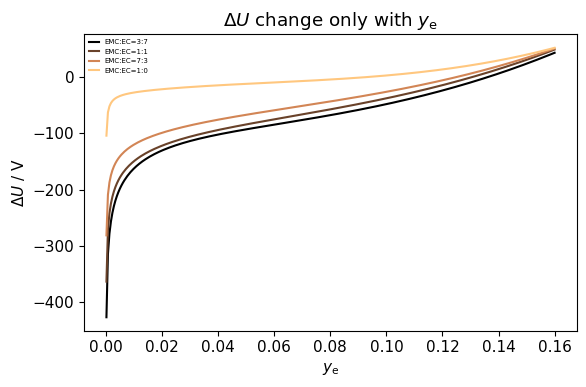

In [159]:
# plot delta_U as one species
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
Y_e = np.linspace(1E-4,0.16,300).tolist(); T=298.75
delta_U_1Species_1 = []; delta_U_1Species_2 = []; 
for y_e in Y_e:
    delta_U_1Species_2.append(LJP_1_Specie_y_np(y_e,T))
fig, ax = plt.subplots(figsize=(6, 4), tight_layout='constrained')
Cases = ["EMC:EC=3:7", "EMC:EC=1:1", "EMC:EC=7:3", "EMC:EC=1:0"]
cop2 = mpl.cm.get_cmap("copper", len(Cases))
Ratios = [7/10, 1/2, 3/10, 0]
for i in range(len(Cases)):
    x_plot = Y_e
    y_plot = []
    for y_e in Y_e:
        y_EC = (1-2*y_e) * Ratios[i]
        y_plot.append( LJP_2_Species_y_np(y_e, y_EC)*1e3  ) 
    ax.plot(x_plot, y_plot,"-",color=cop2(i),label=Cases[i])

#ax.plot(Y_e,np.array(delta_U_1Species_2)*1e3,'--',label="EMC:EC=1:1-single")
ax.legend(prop={'family':'DejaVu Sans','size':fs-6},
    frameon=False,markerscale=1,borderpad=0.2,
    handlelength=1.5,columnspacing=1)
ax.set_ylabel("$\Delta U$ / V")
ax.set_title("$\Delta U$ change only with $y_\mathrm{e}$")
ax.set_xlabel("$y_\mathrm{e}$")


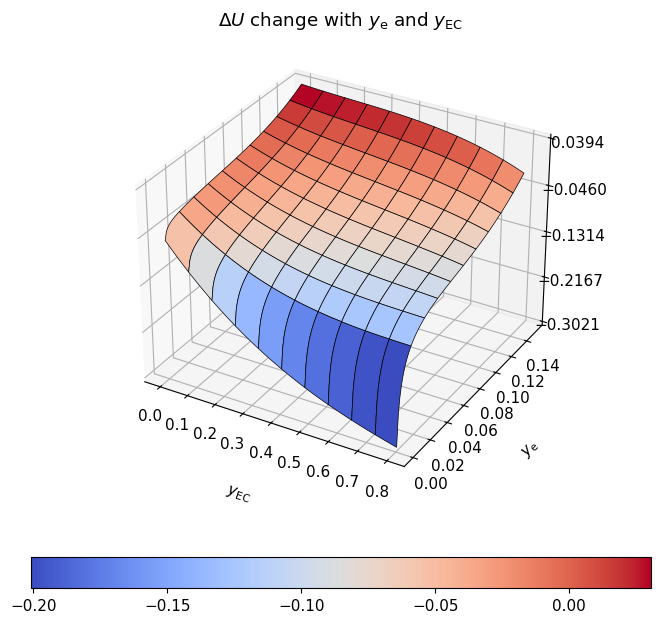

In [160]:
# Plot LJP 2D
Y_e = np.linspace(1E-3,0.15,100).tolist(); 
Y_o = np.linspace(1E-3,0.80,100).tolist(); 
Y_o, Y_e = np.meshgrid(Y_o, Y_e)
delta_U2 = LJP_2_Species_y_np(Y_e,Y_o)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(20, 8))
# Plot the surface.
surf = ax.plot_surface(
    Y_o, Y_e, delta_U2,
    rstride=10, cstride=10, cmap=cm.coolwarm, # Adjusting rstride and cstride for less density
    linewidth=0.5, edgecolor='k', antialiased=True) 

ax.zaxis.set_major_locator(LinearLocator(5))

ax.set_zlabel("$\Delta U$ / V")
ax.set_title("$\Delta U$ change with $y_\mathrm{e}$ and $y_\mathrm{EC}$")
ax.set_ylabel("$y_\mathrm{e}$",)
ax.set_xlabel("$y_\mathrm{EC}$")

ax.xaxis.labelpad = 15  # Adjust the x-axis label position
ax.yaxis.labelpad = 15  # Adjust the y-axis label position
ax.zaxis.labelpad = 40  # Adjust the z-axis label position

# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:1.f}')

# Add a color bar which maps values to colors.
cbar = fig.colorbar(surf, orientation='horizontal', pad=0.1, shrink=0.4)


In [161]:
# Get junction coefficients
def Fun_u_EC(y_e, y_EC): # Eq. (12) in Jung 2023 paper
    T  = 298.15
    # constant first
    R = 8.31446261815324; F = 96485.3321
    # x,y=symbols("x y",real=True)
    # d_deltaU_dyEC = diff(LJP_2_Species_y_sy(x,y),y) # x: y_e; y: y_EC
    d_deltaU_dyEC = 0.174966463856865*y_EC*(-2*y_e - y_EC + 1) - 0.0256925791272929*y_EC*(89.6*y_e + 6.81*y_EC - 12.6) + 0.0256925791272929*(-2*y_e - y_EC + 1)*(89.6*y_e + 6.81*y_EC - 12.6) + (12.2784835649333*y_e**2 - 2.26403007269705*y_e + 0.0776943592809339*np.log(y_e) + 0.211527003955003)/(1 - 2*y_e) - (-1.10889171513396*y_e**0.5 - 10.4851415418483*y_e**3 + 6.0865719952557*y_e**2 + 4.76340417020011*y_e - 10.3386938408227*y_e**1.5 + 6.51820732459422*y_e**2.5 + 64.462681030378*y_e**3.5 - 74.1487833613674*y_e**4.5 + 0.0301630878954419*np.log(y_e) + 0.184138714605309)/(1 - 2*y_e)

    u_EC = F/(R*T) * d_deltaU_dyEC   # .subs({x:y_e,  y:y_EC })
    return u_EC

def Fun_y_e_u_e(y_e, y_EC): # Eq. (12) in Jung 2023 paper
    T  = 298.15
    # constant first
    R = 8.31446261815324; F = 96485.3321
    # x,y=symbols("x y",real=True)
    # d_deltaU_dye = diff(LJP_2_Species_y_sy(x,y),x) # x: y_e; y: y_EC
    d_deltaU_dye = 2.30205508980545*y_EC*(-2*y_e - y_EC + 1) - 0.0513851582545859*y_EC*(89.6*y_e + 6.81*y_EC - 12.6) + y_EC*(24.5569671298666*y_e - 2.26403007269705 + 0.0776943592809339/y_e)/(1 - 2*y_e) + 2*y_EC*(12.2784835649333*y_e**2 - 2.26403007269705*y_e + 0.0776943592809339*np.log(y_e) + 0.211527003955003)/(1 - 2*y_e)**2 - 2*y_EC*(-1.10889171513396*y_e**0.5 - 10.4851415418483*y_e**3 + 6.0865719952557*y_e**2 + 4.76340417020011*y_e - 10.3386938408227*y_e**1.5 + 6.51820732459422*y_e**2.5 + 64.462681030378*y_e**3.5 - 74.1487833613674*y_e**4.5 + 0.0301630878954419*np.log(y_e) + 0.184138714605309)/(1 - 2*y_e)**2 + (-y_EC/(1 - 2*y_e) + 1)*(-0.554445857566982/y_e**0.5 - 15.508040761234*y_e**0.5 - 31.4554246255448*y_e**2 + 12.1731439905114*y_e + 16.2955183114856*y_e**1.5 + 225.619383606323*y_e**2.5 - 333.669525126154*y_e**3.5 + 4.76340417020011 + 0.0301630878954419/y_e)

    u_e = F/(R*T) * d_deltaU_dye    # .subs({x:y_e,  y:y_EC })
    return u_e * y_e

/tmp/ipykernel_6061/716899262.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap  = mpl.cm.get_cmap("cool", len(y_e_list))
/tmp/ipykernel_6061/716899262.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cop2 = mpl.cm.get_cmap("copper", len(Cases))


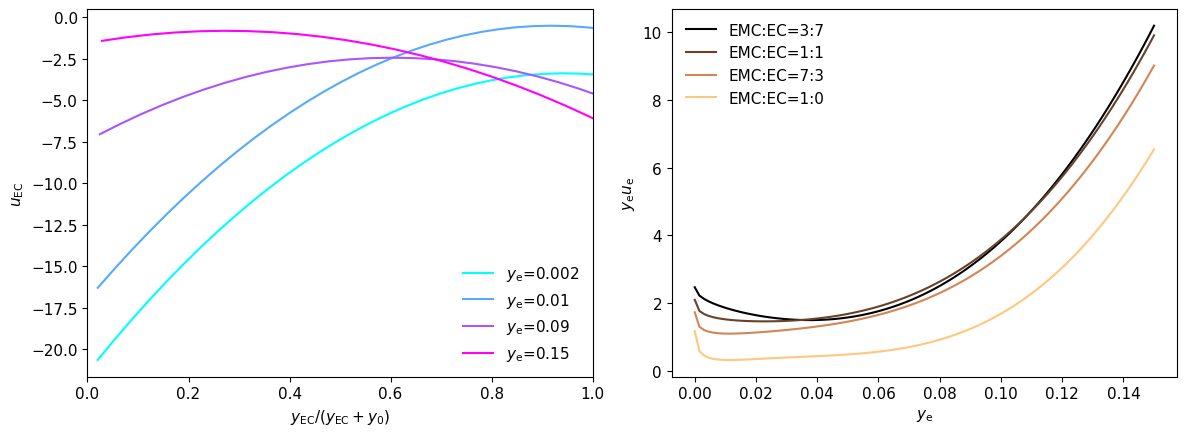

In [162]:
# Plot junction coefficients
fig, axs = plt.subplots(1,2, figsize=(12,4.5),tight_layout=True)
# plot the first one:
y_e_list = [0.002, 0.01, 0.09, 0.15]
T=298.75
y_EC_array = np.linspace(0.02,1.00,30)
cmap  = mpl.cm.get_cmap("cool", len(y_e_list)) 

for i in range(len(y_e_list)):
    x_plot = y_EC_array / (1-2*y_e_list[i])
    y_plot = []
    for y_EC in y_EC_array:
        y_plot.append(Fun_u_EC(y_e_list[i], y_EC))
    axs[0].plot(x_plot, y_plot,"-",color=cmap(i),label=r"$y_\mathrm{e}$=" + f"{y_e_list[i]}")
axs[0].set_xlim(0,1)
axs[0].set_xlabel("$y_\mathrm{EC} / (y_\mathrm{EC}+y_\mathrm{0})$")
axs[0].set_ylabel("$u_\mathrm{EC}$")
axs[0].legend(frameon=False)
# Plot the second one:
y_e_array = np.linspace(1e-10,0.15,100)
# EMC:EC=3:7, 1:1, 7:3, 1:0
Cases = ["EMC:EC=3:7", "EMC:EC=1:1", "EMC:EC=7:3", "EMC:EC=1:0"]
cop2 = mpl.cm.get_cmap("copper", len(Cases))
Ratios = [7/10, 1/2, 3/10, 0]
for i in range(len(Cases)):
    x_plot = y_e_array
    y_plot = []
    for y_e in y_e_array:
        y_EC = (1-2*y_e) * Ratios[i]
        y_plot.append( Fun_y_e_u_e(y_e, y_EC)  ) 
    axs[1].plot(x_plot, y_plot,"-",color=cop2(i),label=Cases[i])
axs[1].set_ylabel("$y_\mathrm{e}u_\mathrm{e}$")
axs[1].set_xlabel("$y_\mathrm{e}$")
axs[1].legend(frameon=False)

In [163]:
# Implement Eq. (23) in Jung 2023 paper:
D_oo = 5e-10; D_ee = 3e-10
# Define the symbols used in the matrix
D_oe, D_eo, cur_D_o, cur_D_e, cur_D_x, = symbols(
    'D_oe D_eo cur_D_o cur_D_e cur_D_x',real=True)
X_oo, X_oe, X_eo, X_ee, y_e, y_o = symbols(
    'X_oo X_oe X_eo X_ee y_e y_o',real=True)
u_o, u_e_y_e, t_0plus,Xi_tilde = symbols(
    'u_o u_e_y_e t_0plus Xi_tilde',real=True)
y_zero = 1-2*y_e-y_o
C_11 = 1 + 2*y_e / y_zero + (V_bar_o*y_o) / (V_bar_zero*y_zero) 
C_12 = (V_bar_e - 2*V_bar_zero)*y_o / (V_bar_zero*y_zero) 
C_21 = (V_bar_o - V_bar_zero)*y_e / (V_bar_zero*y_zero) 
C_22 = 1 + y_o/y_zero + (V_bar_e*y_e) / (V_bar_zero*y_zero) 
# Define matrices
D = Matrix([[D_oo, D_oe], [D_eo, D_ee]]) 
cur_D = Matrix([[cur_D_o, 2*cur_D_x*y_o], [cur_D_x*y_e, 2*cur_D_e]])
X = Matrix([[1 + X_oo, X_oe], [X_eo, 2 + X_ee]])
C = Matrix([[C_11, C_12], [C_21, C_22]])
Eq_23 =Eq(cur_D*X*C ,D)
Sol_D = solve(Eq_23, (D_oe, cur_D_o, cur_D_e, cur_D_x)) # solve equations and get expression

# Sol_Xij[X_eo].subs({X_ee:1,t_0plus:0.4,y_e:0.2, y_o:0.4, u_e_y_e:1,u_o:1}) # substitube values
# Implement Eq. (4) and (10) in Jung 2023 paper, to get X_oo,X_eo,X_oe
# Eq. (4)
Eq_4 = Eq( y_o*(1-y_o)*X_eo-y_e*(1-2*y_e)*X_oe , y_e*y_o*(X_ee-2*X_oo))
# Eq. (10)
Eq_10_1 = Eq(u_o     ,  -(Xi_tilde+1)*X_oo + (1-t_0plus)*X_eo/y_e )
Eq_10_2 = Eq(u_e_y_e ,  (2+X_ee)*(1-t_0plus) - Xi_tilde*X_oe*y_e )

# Here we have to assume Eq. (4) has been satisfied, even though it is NOT
Sol_Xij = solve((Eq_10_1, Eq_10_2), (t_0plus,Xi_tilde)) # solve equations and get expression

In [164]:
Sol_Xij[Xi_tilde]

(-X_ee*X_oo*y_e - X_ee*u_o*y_e + X_eo*u_e_y_e - 2*X_oo*y_e - 2*u_o*y_e)/(X_ee*X_oo*y_e - X_eo*X_oe*y_e + 2*X_oo*y_e)

In [165]:
Eq_4

Eq(X_eo*y_o*(1 - y_o) - X_oe*y_e*(1 - 2*y_e), y_e*y_o*(X_ee - 2*X_oo))

In [166]:
Eq_10_1

Eq(u_o, X_eo*(1 - t_0plus)/y_e + X_oo*(-Xi_tilde - 1))

In [167]:
Eq_10_2

Eq(u_e_y_e, -X_oe*Xi_tilde*y_e + (1 - t_0plus)*(X_ee + 2))

In [168]:
Eq_23

Eq(Matrix([
[-3.8158e-5*y_e*(X_oe*cur_D_o + 2*cur_D_x*y_o*(X_ee + 2))/(-0.00020694*y_e - 0.00010347*y_o + 0.00010347) + (2*X_eo*cur_D_x*y_o + cur_D_o*(X_oo + 1))*(2*y_e/(-2*y_e - y_o + 1) + 6.5312e-5*y_o/(-0.00020694*y_e - 0.00010347*y_o + 0.00010347) + 1), -0.000155997*y_o*(2*X_eo*cur_D_x*y_o + cur_D_o*(X_oo + 1))/(-0.00020694*y_e - 0.00010347*y_o + 0.00010347) + (X_oe*cur_D_o + 2*cur_D_x*y_o*(X_ee + 2))*(5.0943e-5*y_e/(-0.00020694*y_e - 0.00010347*y_o + 0.00010347) + y_o/(-2*y_e - y_o + 1) + 1)],
[-3.8158e-5*y_e*(X_oe*cur_D_x*y_e + 2*cur_D_e*(X_ee + 2))/(-0.00020694*y_e - 0.00010347*y_o + 0.00010347) + (2*X_eo*cur_D_e + cur_D_x*y_e*(X_oo + 1))*(2*y_e/(-2*y_e - y_o + 1) + 6.5312e-5*y_o/(-0.00020694*y_e - 0.00010347*y_o + 0.00010347) + 1), -0.000155997*y_o*(2*X_eo*cur_D_e + cur_D_x*y_e*(X_oo + 1))/(-0.00020694*y_e - 0.00010347*y_o + 0.00010347) + (X_oe*cur_D_x*y_e + 2*cur_D_e*(X_ee + 2))*(5.0943e-5*y_e/(-0.00020694*y_e - 0.00010347*y_o + 0.00010347) + y_o/(-2*y_e - y_o + 1) + 1)]]), Ma

In [169]:
print(Eq_4)
print(Eq_10_1)

Eq(X_eo*y_o*(1 - y_o) - X_oe*y_e*(1 - 2*y_e), y_e*y_o*(X_ee - 2*X_oo))
Eq(u_o, X_eo*(1 - t_0plus)/y_e + X_oo*(-Xi_tilde - 1))


In [170]:
# Get X_ee from Self: it is a function of m_e and alp, alp=y_EC/y_EMC
def Fun_rho(c_e, c_EC):
    return 1006.1  + 0.02235185918895445 * c_EC + 0.10065156540490541 * c_e
def Fun_c_T_y(y_e, y_EC):
    denominator = V_bar_zero + (V_bar_o-V_bar_zero)*y_EC + (V_bar_e-2*V_bar_zero)*y_e
    return 1 / denominator
def electrolyte_conductivity_Andrew_2021(y_e,y_EC): # ACS Energy Letter
    return (
        48.93*y_e**1.5 - 
        284.8*y_e**2.5 + 
        817.7*y_e**4) **2
def Fun_t_0plus_Andrew(y_e,y_EC):
    return 0.4107-1.487*y_e+2.547*y_e**2
def Fun_X_e_e(y_e,y_EC):
    u_e_y_e = Fun_y_e_u_e(y_e, y_EC)
    t_0plus = Fun_t_0plus_Andrew(y_e,y_EC)
    return u_e_y_e / (1-t_0plus) - 2
def Fun_X_o_o(y_e,y_EC):
    return 0.5* Fun_X_e_e(y_e,y_EC)
def Fun_Xi_tile(y_e,y_EC):
    u_EC = Fun_u_EC(y_e, y_EC)
    X_oo = Fun_X_o_o(y_e,y_EC)
    Xi_tilde = - u_EC / (1+X_oo)
    return Xi_tilde
# for compare only:
def Fun_X_ij(y_e,y_EC):
    u_e_y_e = Fun_y_e_u_e(y_e, y_EC)
    t_0plus = Fun_t_0plus_Andrew(y_e,y_EC)
    X_ee = u_e_y_e / (1-t_0plus) - 2
    X_oo = 0.5*X_ee
    X_oe = 0; X_eo = 0
    return X_ee,X_eo,X_oe,X_oo



/tmp/ipykernel_6061/1379863551.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cop2 = mpl.cm.get_cmap("cool", 3)


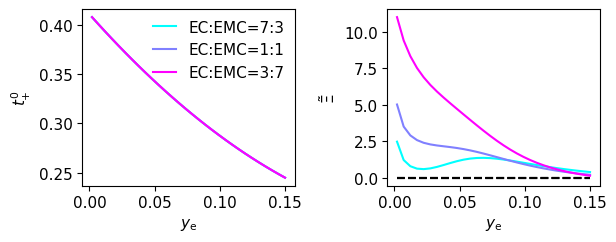

In [193]:
# Plot 
def Plot_t_0plus_Xitilde(Case_No,Save_fig):
    y_e_array = np.linspace(0.002,0.15,30)
    Cases = ["EC:EMC=7:3", "EC:EMC=1:1", "EC:EMC=3:7",   ]   # EC:EMC=1:1000","EMC:EC=999:1",
    cop2 = mpl.cm.get_cmap("cool", 3)
    Ratios = [7/10, 1/2, 3/10, ] # 1/1e3
    fig, axs = plt.subplots(1,2, figsize=(16/2.54,6.5/2.54),tight_layout=True)
    # axs = Axs.flatten()
    for i in range(len(Cases)):
        x_plot = y_e_array
        t_0plus_List = [];Xi_tilde_List = []; X_ee_List = []; X_oo_List=[]
        for y_e_i in y_e_array:
            y_o_i = (1-2*y_e_i) * Ratios[i]
            t_0plus_sol = Fun_t_0plus_Andrew(y_e_i,y_o_i)
            Xi_tilde_sol =Fun_Xi_tile(y_e_i,y_o_i)
            X_ee = Fun_X_e_e(y_e_i,y_o_i)
            X_oo = Fun_X_o_o(y_e_i,y_o_i)
            t_0plus_List.append( t_0plus_sol  ) 
            Xi_tilde_List.append( Xi_tilde_sol  ) 
            #X_ee_List.append(X_ee)
            #X_oo_List.append(X_oo)

        axs[0].plot(x_plot, t_0plus_List,"-",color=cop2(i),label=Cases[i])
        axs[1].plot(x_plot, Xi_tilde_List,"-",color=cop2(i),label=Cases[i])
        axs[1].plot(x_plot,np.zeros(np.size(Xi_tilde_List)),"--",color="k")
        #axs[2].plot(x_plot, X_ee_List,"-",color=cop2(i),label=Cases[i])
        #axs[3].plot(x_plot, X_oo_List,"-",color=cop2(i),label=Cases[i])

    axs[0].set_ylabel(r'$t_{+}^{0}$')
    axs[1].set_ylabel(r'$\tilde{\Xi}$') 
    for i in range(2):
        axs[i].set_xlabel("$y_\mathrm{e}$")
    axs[0].legend(prop={'family':'DejaVu Sans','size':fs},
        frameon=False,markerscale=1,borderpad=0.2,
        handlelength=1.5,columnspacing=1)
    if Save_fig:
        plt.savefig(Path_Fig_save + "/" +  f"Case_{Case_No}_t_0plus_Xitilde.png", dpi=600)
        plt.savefig(Path_Fig_save + "/" +  f"Case_{Case_No}_t_0plus_Xitilde.svg") 
    return 
Plot_t_0plus_Xitilde(Case_No,Save_fig=True)

In [190]:
Path_Fig_save

'/home/ruihe_li/EnvPBGEM_ECDrag2/Double_SimSave/Double_Trans/Plot_Elely_Landes_Cond/'

Text(0.5, 0, 'sqrt($y_\\mathrm{e}$)')

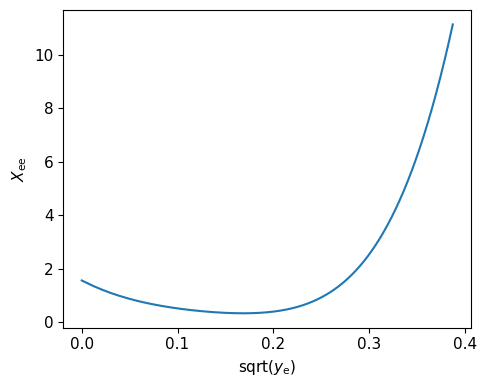

In [172]:
# Now just look at X_ee, see how it behave when y_e approches 0 - it should be correct
y_e_array = np.linspace(1e-10,0.15,1000)
y_plot_ee = []
for y_e_i in y_e_array:
    y_o_i = (1-2*y_e_i) * 1/2 # fix y_o as it doesn't matter
    X_ee_sol = Fun_X_e_e(y_e_i,y_o_i)
    y_plot_ee.append( X_ee_sol  ) 

fig, ax = plt.subplots( figsize=(5,4),tight_layout=True)
ax.plot(np.sqrt(y_e_array), y_plot_ee,"-",)
ax.set_ylabel("$X_\mathrm{ee}$")
ax.set_xlabel("sqrt($y_\mathrm{e}$)")

In [173]:
y_e_sub = 0.074; y_o_sub = 0.46
X_ee_sub = Fun_X_e_e(y_e_sub,y_o_sub); print(X_ee_sub)
X_oo_sol = Fun_X_o_o(y_e_sub,y_o_sub); print(X_oo_sol)
X_eo_sol = 0; X_oe_sol = 0


1.4657479316108186
0.7328739658054093


In [174]:
D_oe_sol = Sol_D[D_oe].subs({
    y_e:y_e_sub,   y_o:y_o_sub, }) 
# print(D_oe_sol)
D_oe_sol2 = D_oe_sol.subs({
    X_ee :1 , D_oe:1E-14, D_eo:1E-14}) 
print(D_oe_sol2)

(-7801.847132424*X_ee + 237138.40499304*X_eo - 34012.70214*X_oe + 26550.6894*X_oo + 10946.995135152)/(2089532080000.0*X_oe - 63578816800000.0*X_oo - 63578816800000.0)


In [175]:
print(Sol_D[D_oe])

(3.11994e+15*D_eo*X_ee*y_e*y_o - 2.0694e+15*D_eo*X_ee*y_o + 3.11994e+15*D_eo*X_eo*y_o**2 + 6.23988e+15*D_eo*y_e*y_o - 4.1388e+15*D_eo*y_o - 228948.0*X_ee*y_e*y_o - 228948.0*X_eo*y_o**2 + 620820.0*X_eo*y_o + 779985.0*X_oe*y_e**2 - 517350.0*X_oe*y_e + 779985.0*X_oo*y_e*y_o + 322089.0*y_e*y_o)/(381580000000000.0*X_oe*y_e**2 + 381580000000000.0*X_oo*y_e*y_o - 1.0347e+15*X_oo*y_e + 381580000000000.0*y_e*y_o - 1.0347e+15*y_e)


In [176]:
def Fun_D(y_e,y_o):
    X_ee = Fun_X_e_e(y_e,y_o)
    X_oo = Fun_X_o_o(y_e,y_o)
    X_eo = 0; X_oe = 0
    D_oe_sol = (3.11994e+15*D_eo*X_ee*y_e*y_o - 2.0694e+15*D_eo*X_ee*y_o + 3.11994e+15*D_eo*X_eo*y_o**2 + 6.23988e+15*D_eo*y_e*y_o - 4.1388e+15*D_eo*y_o - 228948.0*X_ee*y_e*y_o - 228948.0*X_eo*y_o**2 + 620820.0*X_eo*y_o + 779985.0*X_oe*y_e**2 - 517350.0*X_oe*y_e + 779985.0*X_oo*y_e*y_o + 322089.0*y_e*y_o)/(381580000000000.0*X_oe*y_e**2 + 381580000000000.0*X_oo*y_e*y_o - 1.0347e+15*X_oo*y_e + 381580000000000.0*y_e*y_o - 1.0347e+15*y_e)
    cur_D_o_sol = (1.1905067052e+20*D_eo*X_ee**2*y_e**3*y_o + 5.952533526e+19*D_eo*X_ee**2*y_e**2*y_o**2 - 1.3848950046e+20*D_eo*X_ee**2*y_e**2*y_o - 3.94820826e+19*D_eo*X_ee**2*y_e*y_o**2 + 3.94820826e+19*D_eo*X_ee**2*y_e*y_o + 2.3810134104e+20*D_eo*X_ee*X_eo*y_e**2*y_o**2 - 3.228201918e+20*D_eo*X_ee*X_eo*y_e**2*y_o + 1.1905067052e+20*D_eo*X_ee*X_eo*y_e*y_o**3 - 3.5942493162e+20*D_eo*X_ee*X_eo*y_e*y_o**2 + 3.755309139e+20*D_eo*X_ee*X_eo*y_e*y_o - 3.94820826e+19*D_eo*X_ee*X_eo*y_o**3 + 1.465424916e+20*D_eo*X_ee*X_eo*y_o**2 - 1.07060409e+20*D_eo*X_ee*X_eo*y_o + 4.7620268208e+20*D_eo*X_ee*y_e**3*y_o + 2.3810134104e+20*D_eo*X_ee*y_e**2*y_o**2 - 5.5395800184e+20*D_eo*X_ee*y_e**2*y_o - 1.579283304e+20*D_eo*X_ee*y_e*y_o**2 + 1.579283304e+20*D_eo*X_ee*y_e*y_o + 1.1905067052e+20*D_eo*X_eo**2*y_e*y_o**3 - 3.228201918e+20*D_eo*X_eo**2*y_e*y_o**2 + 5.952533526e+19*D_eo*X_eo**2*y_o**4 - 2.2093543116e+20*D_eo*X_eo**2*y_o**3 + 1.614100959e+20*D_eo*X_eo**2*y_o**2 + 4.7620268208e+20*D_eo*X_eo*y_e**2*y_o**2 - 6.456403836e+20*D_eo*X_eo*y_e**2*y_o + 2.3810134104e+20*D_eo*X_eo*y_e*y_o**3 - 7.1884986324e+20*D_eo*X_eo*y_e*y_o**2 + 7.510618278e+20*D_eo*X_eo*y_e*y_o - 7.89641652e+19*D_eo*X_eo*y_o**3 + 2.930849832e+20*D_eo*X_eo*y_o**2 - 2.14120818e+20*D_eo*X_eo*y_o + 4.7620268208e+20*D_eo*y_e**3*y_o + 2.3810134104e+20*D_eo*y_e**2*y_o**2 - 5.5395800184e+20*D_eo*y_e**2*y_o - 1.579283304e+20*D_eo*y_e*y_o**2 + 1.579283304e+20*D_eo*y_e*y_o - 8736197784.0*X_ee**2*y_e**3*y_o - 4368098892.0*X_ee**2*y_e**2*y_o**2 + 4368098892.0*X_ee**2*y_e**2*y_o - 17472395568.0*X_ee*X_eo*y_e**2*y_o**2 + 47378499120.0*X_ee*X_eo*y_e**2*y_o - 8736197784.0*X_ee*X_eo*y_e*y_o**3 + 32425447344.0*X_ee*X_eo*y_e*y_o**2 - 23689249560.0*X_ee*X_eo*y_e*y_o + 80705047950.0*X_ee*X_oo*y_e**3 + 60093565275.0*X_ee*X_oo*y_e**2*y_o - 93882728475.0*X_ee*X_oo*y_e**2 + 9870520650.0*X_ee*X_oo*y_e*y_o**2 - 36635622900.0*X_ee*X_oo*y_e*y_o + 26765102250.0*X_ee*X_oo*y_e - 34944791136.0*X_ee*y_e**3*y_o + 80705047950.0*X_ee*y_e**3 - 17472395568.0*X_ee*y_e**2*y_o**2 + 77565960843.0*X_ee*y_e**2*y_o - 93882728475.0*X_ee*y_e**2 + 9870520650.0*X_ee*y_e*y_o**2 - 36635622900.0*X_ee*y_e*y_o + 26765102250.0*X_ee*y_e - 8736197784.0*X_eo**2*y_e*y_o**3 + 47378499120.0*X_eo**2*y_e*y_o**2 - 64236245400.0*X_eo**2*y_e*y_o - 4368098892.0*X_eo**2*y_o**4 + 28057348452.0*X_eo**2*y_o**3 - 55807372260.0*X_eo**2*y_o**2 + 32118122700.0*X_eo**2*y_o - 80705047950.0*X_eo*X_oe*y_e**3 - 60093565275.0*X_eo*X_oe*y_e**2*y_o + 93882728475.0*X_eo*X_oe*y_e**2 - 9870520650.0*X_eo*X_oe*y_e*y_o**2 + 36635622900.0*X_eo*X_oe*y_e*y_o - 26765102250.0*X_eo*X_oe*y_e - 34944791136.0*X_eo*y_e**2*y_o**2 + 94756998240.0*X_eo*y_e**2*y_o - 17472395568.0*X_eo*y_e*y_o**3 + 64850894688.0*X_eo*y_e*y_o**2 - 47378499120.0*X_eo*y_e*y_o + 161410095900.0*X_oo*y_e**3 + 120187130550.0*X_oo*y_e**2*y_o - 187765456950.0*X_oo*y_e**2 + 19741041300.0*X_oo*y_e*y_o**2 - 73271245800.0*X_oo*y_e*y_o + 53530204500.0*X_oo*y_e - 34944791136.0*y_e**3*y_o + 161410095900.0*y_e**3 - 17472395568.0*y_e**2*y_o**2 + 137659526118.0*y_e**2*y_o - 187765456950.0*y_e**2 + 19741041300.0*y_e*y_o**2 - 73271245800.0*y_e*y_o + 53530204500.0*y_e)/(2.976266763e+19*X_ee*X_oe*X_oo*y_e**3 + 7.28016482e+18*X_ee*X_oe*X_oo*y_e**2*y_o - 1.97410413e+19*X_ee*X_oe*X_oo*y_e**2 + 2.976266763e+19*X_ee*X_oe*y_e**3 + 7.28016482e+18*X_ee*X_oe*y_e**2*y_o - 1.97410413e+19*X_ee*X_oe*y_e**2 + 2.976266763e+19*X_ee*X_oo**2*y_e**2*y_o - 8.070504795e+19*X_ee*X_oo**2*y_e**2 + 7.28016482e+18*X_ee*X_oo**2*y_e*y_o**2 - 3.94820826e+19*X_ee*X_oo**2*y_e*y_o + 5.35302045e+19*X_ee*X_oo**2*y_e + 5.952533526e+19*X_ee*X_oo*y_e**2*y_o - 1.614100959e+20*X_ee*X_oo*y_e**2 + 1.456032964e+19*X_ee*X_oo*y_e*y_o**2 - 7.89641652e+19*X_ee*X_oo*y_e*y_o + 1.07060409e+20*X_ee*X_oo*y_e + 2.976266763e+19*X_ee*y_e**2*y_o - 8.070504795e+19*X_ee*y_e**2 + 7.28016482e+18*X_ee*y_e*y_o**2 - 3.94820826e+19*X_ee*y_e*y_o + 5.35302045e+19*X_ee*y_e - 2.976266763e+19*X_eo*X_oe**2*y_e**3 - 7.28016482e+18*X_eo*X_oe**2*y_e**2*y_o + 1.97410413e+19*X_eo*X_oe**2*y_e**2 - 2.976266763e+19*X_eo*X_oe*X_oo*y_e**2*y_o + 8.070504795e+19*X_eo*X_oe*X_oo*y_e**2 - 7.28016482e+18*X_eo*X_oe*X_oo*y_e*y_o**2 + 3.94820826e+19*X_eo*X_oe*X_oo*y_e*y_o - 5.35302045e+19*X_eo*X_oe*X_oo*y_e - 2.976266763e+19*X_eo*X_oe*y_e**2*y_o + 8.070504795e+19*X_eo*X_oe*y_e**2 - 7.28016482e+18*X_eo*X_oe*y_e*y_o**2 + 3.94820826e+19*X_eo*X_oe*y_e*y_o - 5.35302045e+19*X_eo*X_oe*y_e + 5.952533526e+19*X_oe*X_oo*y_e**3 + 1.456032964e+19*X_oe*X_oo*y_e**2*y_o - 3.94820826e+19*X_oe*X_oo*y_e**2 + 5.952533526e+19*X_oe*y_e**3 + 1.456032964e+19*X_oe*y_e**2*y_o - 3.94820826e+19*X_oe*y_e**2 + 5.952533526e+19*X_oo**2*y_e**2*y_o - 1.614100959e+20*X_oo**2*y_e**2 + 1.456032964e+19*X_oo**2*y_e*y_o**2 - 7.89641652e+19*X_oo**2*y_e*y_o + 1.07060409e+20*X_oo**2*y_e + 1.1905067052e+20*X_oo*y_e**2*y_o - 3.228201918e+20*X_oo*y_e**2 + 2.912065928e+19*X_oo*y_e*y_o**2 - 1.579283304e+20*X_oo*y_e*y_o + 2.14120818e+20*X_oo*y_e + 5.952533526e+19*y_e**2*y_o - 1.614100959e+20*y_e**2 + 1.456032964e+19*y_e*y_o**2 - 7.89641652e+19*y_e*y_o + 1.07060409e+20*y_e)
    cur_D_e_sol = (1.55997e+15*D_eo*X_oe*y_e**2 + 779985000000000.0*D_eo*X_oe*y_e*y_o - 1.814685e+15*D_eo*X_oe*y_e - 517350000000000.0*D_eo*X_oe*y_o + 517350000000000.0*D_eo*X_oe + 1.55997e+15*D_eo*X_oo*y_e*y_o + 779985000000000.0*D_eo*X_oo*y_o**2 - 779985000000000.0*D_eo*X_oo*y_o + 1.55997e+15*D_eo*y_e*y_o + 779985000000000.0*D_eo*y_o**2 - 779985000000000.0*D_eo*y_o - 114474.0*X_oe*y_e**2 - 57237.0*X_oe*y_e*y_o + 57237.0*X_oe*y_e - 114474.0*X_oo*y_e*y_o + 310410.0*X_oo*y_e - 57237.0*X_oo*y_o**2 + 212442.0*X_oo*y_o - 155205.0*X_oo - 114474.0*y_e*y_o + 310410.0*y_e - 57237.0*y_o**2 + 212442.0*y_o - 155205.0)/(1.55997e+15*X_ee*X_oo*y_e + 381580000000000.0*X_ee*X_oo*y_o - 1.0347e+15*X_ee*X_oo + 1.55997e+15*X_ee*y_e + 381580000000000.0*X_ee*y_o - 1.0347e+15*X_ee - 1.55997e+15*X_eo*X_oe*y_e - 381580000000000.0*X_eo*X_oe*y_o + 1.0347e+15*X_eo*X_oe + 3.11994e+15*X_oo*y_e + 763160000000000.0*X_oo*y_o - 2.0694e+15*X_oo + 3.11994e+15*y_e + 763160000000000.0*y_o - 2.0694e+15)
    cur_D_x_sol = (-1.55997e+15*D_eo*X_ee*y_e**2 - 779985000000000.0*D_eo*X_ee*y_e*y_o + 1.814685e+15*D_eo*X_ee*y_e + 517350000000000.0*D_eo*X_ee*y_o - 517350000000000.0*D_eo*X_ee - 1.55997e+15*D_eo*X_eo*y_e*y_o - 779985000000000.0*D_eo*X_eo*y_o**2 + 779985000000000.0*D_eo*X_eo*y_o - 3.11994e+15*D_eo*y_e**2 - 1.55997e+15*D_eo*y_e*y_o + 3.62937e+15*D_eo*y_e + 1.0347e+15*D_eo*y_o - 1.0347e+15*D_eo + 114474.0*X_ee*y_e**2 + 57237.0*X_ee*y_e*y_o - 57237.0*X_ee*y_e + 114474.0*X_eo*y_e*y_o - 310410.0*X_eo*y_e + 57237.0*X_eo*y_o**2 - 212442.0*X_eo*y_o + 155205.0*X_eo + 228948.0*y_e**2 + 114474.0*y_e*y_o - 114474.0*y_e)/(779985000000000.0*X_ee*X_oo*y_e**2 + 190790000000000.0*X_ee*X_oo*y_e*y_o - 517350000000000.0*X_ee*X_oo*y_e + 779985000000000.0*X_ee*y_e**2 + 190790000000000.0*X_ee*y_e*y_o - 517350000000000.0*X_ee*y_e - 779985000000000.0*X_eo*X_oe*y_e**2 - 190790000000000.0*X_eo*X_oe*y_e*y_o + 517350000000000.0*X_eo*X_oe*y_e + 1.55997e+15*X_oo*y_e**2 + 381580000000000.0*X_oo*y_e*y_o - 1.0347e+15*X_oo*y_e + 1.55997e+15*y_e**2 + 381580000000000.0*y_e*y_o - 1.0347e+15*y_e)
    return D_oe_sol,cur_D_o_sol,cur_D_e_sol,cur_D_x_sol
def Fun_det_D(y_e,y_o):
    X_ee = Fun_X_e_e(y_e,y_o)
    X_oo = Fun_X_o_o(y_e,y_o)
    X_eo = 0; X_oe = 0
    D_oo = 5e-10; D_ee = 3e-10
    D_oe_sol = (3.11994e+15*D_eo*X_ee*y_e*y_o - 2.0694e+15*D_eo*X_ee*y_o + 3.11994e+15*D_eo*X_eo*y_o**2 + 6.23988e+15*D_eo*y_e*y_o - 4.1388e+15*D_eo*y_o - 228948.0*X_ee*y_e*y_o - 228948.0*X_eo*y_o**2 + 620820.0*X_eo*y_o + 779985.0*X_oe*y_e**2 - 517350.0*X_oe*y_e + 779985.0*X_oo*y_e*y_o + 322089.0*y_e*y_o)/(381580000000000.0*X_oe*y_e**2 + 381580000000000.0*X_oo*y_e*y_o - 1.0347e+15*X_oo*y_e + 381580000000000.0*y_e*y_o - 1.0347e+15*y_e)
    return D_oo*D_ee - D_oe_sol*D_eo

In [177]:
# Now we look at diffusivities
# First, find out range of D_eo
def Fun_D_WRONG(y_e_sub,y_o_sub):
    X_ee_sub = Fun_X_e_e(y_e_sub,y_o_sub)
    X_oo_sol = Fun_X_o_o(y_e_sub,y_o_sub)
    X_eo_sol = 0; X_oe_sol = 0
    D_oe_sol = Sol_D[D_oe].subs({
        X_ee:X_ee_sub, X_eo:X_eo_sol,
        X_oe:X_oe_sol, X_oo:X_oo_sol,
        y_e:y_e_sub,   y_o:y_o_sub, }) 
    D_oe_sol = D_oe_sol.subs({
        X_ee:X_ee_sub,X_oo:X_oo_sol})
    cur_D_o_sol = Sol_D[cur_D_o].subs({
        X_ee:X_ee_sub, X_eo:X_eo_sol,
        X_oe:X_oe_sol, X_oo:X_oo_sol,
        y_e:y_e_sub,   y_o:y_o_sub, }) 
    cur_D_e_sol =  Sol_D[cur_D_e].subs({
        X_ee:X_ee_sub, X_eo:X_eo_sol,
        X_oe:X_oe_sol, X_oo:X_oo_sol,
        y_e:y_e_sub,   y_o:y_o_sub, }) 
    cur_D_x_sol =  Sol_D[cur_D_x].subs({
        X_ee:X_ee_sub, X_eo:X_eo_sol,
        X_oe:X_oe_sol, X_oo:X_oo_sol,
        y_e:y_e_sub,   y_o:y_o_sub, }) 
    return D_oe_sol,cur_D_o_sol,cur_D_e_sol,cur_D_x_sol
def Fun_det_D_WRONG(y_e_sub,y_o_sub):
    X_ee_sub = Fun_X_e_e(y_e_sub,y_o_sub)
    X_oo_sol = Fun_X_o_o(y_e_sub,y_o_sub)
    X_eo_sol = 0; X_oe_sol = 0
    D_oo = 5e-10; D_ee = 3e-10
    D_oe_sol = Sol_D[D_oe].subs({
        X_ee:X_ee_sub, X_eo:X_eo_sol,
        X_oe:X_oe_sol, X_oo:X_oo_sol,
        y_e:y_e_sub,   y_o:y_o_sub, }) 
    return 5e-10*3e-10 - D_oe_sol*D_eo


In [178]:
y_e_sub = 0.074; y_o_sub = 0.46
D_oe_sol,cur_D_o_sol,cur_D_e_sol,cur_D_x_sol = Fun_D(y_e_sub,y_o_sub)

In [179]:
det_D_1 = Fun_det_D(y_e_sub,y_o_sub)
D_eo_i = solve(Eq(det_D_1 ,0),D_eo)
det_D_1.subs({D_eo:1e-14})

1.50001721799128e-19

In [180]:
# The data file are the same from 
Path_Data_pre = os.path.expanduser("~/EnvPBGEM_ECDrag2/Double_SimSave/Double_Trans/Input/")
Save_fig = True
Jung_2023_Data = pd.read_excel(Path_Data_pre+'Jung_2023_ACS_Omega_Table_S3.xlsx')
Jung_2023_Data.head()
Jung_2023_Data_f1 = Jung_2023_Data[Jung_2023_Data["y_e"] != 0]
Jung_2023_Data_f1 = Jung_2023_Data_f1[Jung_2023_Data_f1["y_o"] != 0]
Jung_2023_Data_f1= Jung_2023_Data_f1.reset_index(drop=True)
y_EC_exp_List = Jung_2023_Data_f1["y_o"].tolist()
y_e_exp_List  = Jung_2023_Data_f1["y_e"].tolist()

This determines that D_eo should be between -1e-11 and 1.5e-11 m2/s


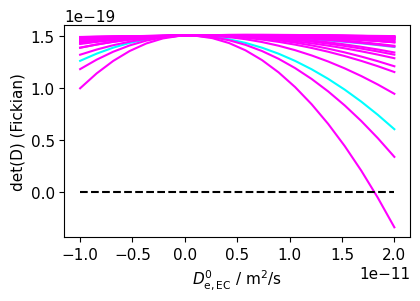

In [196]:
# Determine range for D_eo
def Plot_Range_D_eo(Save_fig):
    D_eo_list = np.linspace(-1e-11,2e-11,20)
    fig, axs = plt.subplots(figsize=(11/2.54,8/2.54),tight_layout=True)
    for i in range(len(y_e_exp_List)):
        det_D_1 = Fun_det_D(y_e_exp_List[i], y_EC_exp_List[i])
        det_D_1_list = [det_D_1.subs({D_eo:D_eo_i}) for D_eo_i in D_eo_list]
        axs.plot(D_eo_list,det_D_1_list,"-",color=cmap(i))
    axs.plot(D_eo_list,np.zeros(np.size(D_eo_list)),"--",color="k")
    axs.set_xlabel("$D_\mathrm{e,EC}^\mathrm{0}$ / $\mathrm{m}^2$/s")
    axs.set_ylabel("det(D) (Fickian)")
    if Save_fig:
        plt.savefig(Path_Fig_save + "/" +  f"Case_{Case_No}_Determine range for D_eo.png", dpi=600)
        plt.savefig(Path_Fig_save + "/" +  f"Case_{Case_No}_Determine range for D_eo.svg") 
    return
print("This determines that D_eo should be between -1e-11 and 1.5e-11 m2/s")
Plot_Range_D_eo(Save_fig=True)

/tmp/ipykernel_6061/3116871910.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cop2 = mpl.cm.get_cmap("cool", 4)


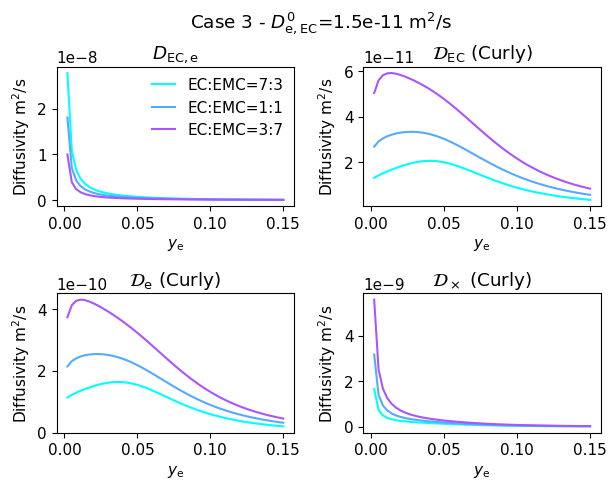

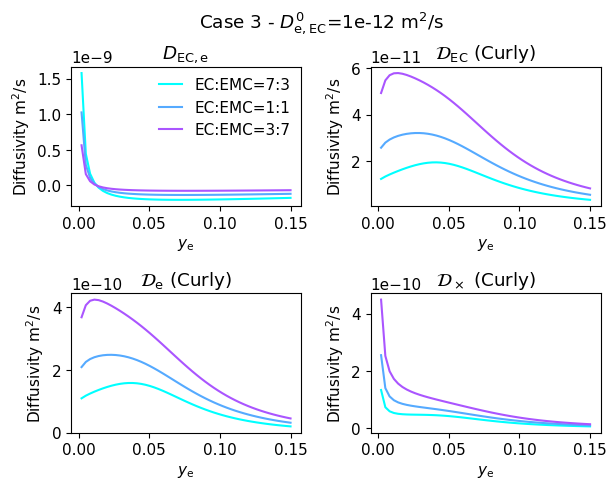

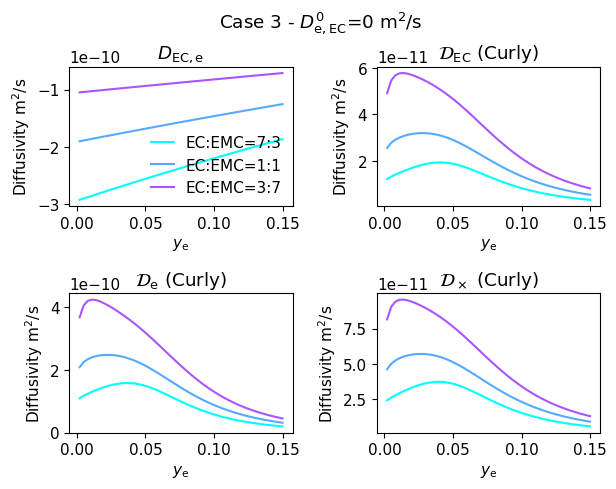

In [199]:
# Plot the four diffusivities
def Plot_4_Diff(D_0_e_EC,Save_fig):
    y_e_array = np.linspace(2e-3,0.15,50)
    # EMC:EC=3:7, 1:1, 7:3
    Cases = ["EC:EMC=7:3", "EC:EMC=1:1", "EC:EMC=3:7",   ] 
    cop2 = mpl.cm.get_cmap("cool", 4)
    Ratios = [7/10, 1/2, 3/10, ] # 1/1e3
    fig, Axs = plt.subplots(2,2, figsize=(16/2.54,13/2.54),tight_layout=True)
    axs = Axs.flatten()
    for i in range(len(Cases)):
        x_plot = y_e_array
        y_plot_ee = [];y_plot_oe = [];y_plot_eo = [];y_plot_oo = [];
        for y_e_i in y_e_array:
            y_o_i = (1-2*y_e_i) * Ratios[i]
            D_oe_sol,cur_D_o_sol,cur_D_e_sol,cur_D_x_sol = Fun_D(y_e_i,y_o_i)
            y_plot_ee.append( D_oe_sol.subs({D_eo:D_0_e_EC})  ) 
            y_plot_eo.append( cur_D_o_sol.subs({D_eo:D_0_e_EC})  ) 
            y_plot_oe.append( cur_D_e_sol.subs({D_eo:D_0_e_EC})  ) 
            y_plot_oo.append( cur_D_x_sol.subs({D_eo:D_0_e_EC})   ) 
        axs[0].plot(x_plot, y_plot_ee,"-",color=cop2(i),label=Cases[i])
        axs[1].plot(x_plot, y_plot_oe,"-",color=cop2(i),label=Cases[i])
        axs[2].plot(x_plot, y_plot_eo,"-",color=cop2(i),label=Cases[i])
        axs[3].plot(x_plot, y_plot_oo,"-",color=cop2(i),label=Cases[i])
    axs[0].set_title("$D_\mathrm{EC,e}$")
    axs[1].set_title(r'$\mathcal{D}_\mathrm{EC}$ (Curly)',)
    axs[2].set_title(r'$\mathcal{D}_\mathrm{e}$ (Curly)',)
    axs[3].set_title(r'$\mathcal{D}_\times$ (Curly)')
    for i in range(4):
        axs[i].set_xlabel("$y_\mathrm{e}$")
        axs[i].set_ylabel(r'Diffusivity $\mathrm{m}^2/\mathrm{s}$')
    axs[0].legend(prop={'family':'DejaVu Sans','size':fs},
        frameon=False,markerscale=1,borderpad=0.2,
        handlelength=1.5,columnspacing=1)
    fig.suptitle(
        r"Case 3 - $D_\mathrm{e,EC}^\mathrm{0}$"+f"={D_0_e_EC}"+r" m$^2$/s",
        x=0.52, y=0.95)
    if Save_fig:
        plt.savefig(Path_Fig_save + "/" +  f"Case_{Case_No}_Other_diffusivities when D_0_e,EC={D_0_e_EC}.png", dpi=600)
        plt.savefig(Path_Fig_save + "/" +  f"Case_{Case_No}_Other_diffusivities when D_0_e,EC={D_0_e_EC}.svg") 
    return 
Plot_4_Diff(D_0_e_EC = 1.5E-11,Save_fig=True)
Plot_4_Diff(D_0_e_EC = 1E-12,Save_fig=True)
Plot_4_Diff(D_0_e_EC = 0,Save_fig=True)